In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
import pickle as pkl
import random
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
import tensorflow as tf
import keras
import keras_metrics as km
from keras import initializers

from keras.callbacks import TensorBoard
from keras import regularizers
from custom_callbacks import LrFinder
from custom_callbacks import CycleLearner
from custom_callbacks import reset_weights
from keras.callbacks import ModelCheckpoint
from time import time
from keras.layers import Input, Dense,Dropout,BatchNormalization,LSTM,GRU,Bidirectional,Conv2D, MaxPool2D, Flatten, GlobalAvgPool2D, GlobalMaxPool2D,merge,CuDNNGRU,CuDNNLSTM
from keras.models import Model,Sequential
from sklearn.model_selection import train_test_split
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.optimizers import Adagrad
from keras.optimizers import Adamax
from keras.optimizers import Nadam
from keras.optimizers import RMSprop
from keras import backend as K
import math
import json

# Get the dictionary containing each metric and the loss for each epoch


Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8551380561775804124
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10878923572
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2019876716617647223
physical_device_desc: "device: 0, name: TITAN Xp, pci bus id: 0000:02:00.0, compute capability: 6.1"
]


In [3]:
train_filepath = "train_workspace/"
animalList = ["Human","Pig","Chicken","Rat","Mouse","Dog"]
levelList = ["Strict","Relaxed","Intermediate"]
dataList = ["Ohnologs","No-Ohnologs","Paralogs"]
dataNameList = ["ohnologs","no-ohnologs","paralog"]
sb.set_style("darkgrid")

In [4]:
working_level = "Strict"
kmer_chosen = 8
type_chosen = "cdna"

dataset_complete = pd.read_pickle(train_filepath + working_level + "/datasets/2_paralog_dataset_complete-" + str(kmer_chosen) + "-" + type_chosen + ".pkl")
dataset_complete_soft = pd.read_pickle(train_filepath + working_level + "/datasets/3_paralog_dataset_complete-" + str(kmer_chosen) + "-" + type_chosen + ".pkl")

In [5]:
new_classes = []
for index, row in dataset_complete_soft.iterrows():
    if(row["Is_Ohnolog"] == 1):
        new_classes.append(1)
    else:
        if(row["Is_Paralog"] == 0):
            new_classes.append(0)
        else:
            new_classes.append(2)
dataset_complete_soft["Dup_Class"] = new_classes
dataset_complete_soft.head()

,Specie_Chicken,Specie_Dog,Specie_Human,Specie_Mouse,Specie_Pig,Specie_Rat,Is_Ohnolog,Is_Paralog,Sequence-1 GC,Sequence-1 Length,...,Embedding2_91,Embedding2_92,Embedding2_93,Embedding2_94,Embedding2_95,Embedding2_96,Embedding2_97,Embedding2_98,Embedding2_99,Dup_Class
0,0,0,1,0,0,0,1,0.0,0.429090,0.030467,...,35.407509,23.369914,8.144324,-26.702099,241.207709,-12.695194,-79.573883,121.379307,-69.633950,1
1,0,0,1,0,0,0,1,0.0,0.441268,0.053554,...,12.556002,23.217834,3.162621,-18.980361,204.830682,-20.962017,-61.163222,122.543777,-26.694989,1
2,0,0,1,0,0,0,1,0.0,0.357972,0.111632,...,-6.850837,12.314794,-3.387437,-5.403946,93.521862,4.187927,-35.880841,50.565405,-9.853733,1
3,0,0,1,0,0,0,1,0.0,0.684226,0.031676,...,68.287420,6.295047,37.820265,-33.841090,230.696114,-60.500167,-82.975793,174.224105,-111.569089,1
4,0,0,1,0,0,0,1,0.0,0.402629,0.018732,...,18.025175,13.675959,21.304353,-2.702105,162.972440,-8.209692,-46.736790,62.650600,-39.056701,1


## Start Designing

In [6]:
blast_columns = ["Percent Identical Matches","Aligment Length","Nr Mismatch","Nr Gap Open","Evalue","Bit Score"]

e_values_columns = ["Evalue_Total","Evalue_High","Evalue_Medium","Evalue_Low"]

blast_types = ["High","Medium","Low","Total"]
blast_col_Total = [i + "_Total" for i in blast_columns] 
blast_col_High = [i + "_High" for i in blast_columns]
blast_col_Medium = [i + "_Medium" for i in blast_columns]
blast_col_Low = [i + "_Low" for i in blast_columns]

blast_cols_levels = blast_col_High + blast_col_Medium + blast_col_Low
total_columns = (blast_col_High + blast_col_Medium + blast_col_Low + blast_col_Total + ["Nr Hits"])

non_training_meta_features = ["Sequence-1","Sequence-2","Sequence-1 Id","Sequence-1-Transcript Id","Sequence-2 Id","Sequence-2-Transcript Id","Sequence-1-Transcript-Version","Sequence-2-Transcript-Version"]

sequence_1_metadata = ["Sequence-1 GC","Sequence-1 Length","Sequence-1-Chromosome","Seq-1-Biotype_protein_coding"]
sequence_2_metadata = ["Sequence-2 GC","Sequence-2 Length","Sequence-2-Chromosome","Seq-2-Biotype_protein_coding"]

sequence_1_metadata_diferential = ["Sequence-1 GC","Sequence-1 Length"]
sequence_2_metadata_diferential = ["Sequence-2 GC","Sequence-2 Length"]

sequence_1_metadata_categorical = ["Sequence-1-Chromosome","Seq-1-Biotype_protein_coding"]
sequence_2_metadata_categorical = ["Sequence-2-Chromosome","Seq-2-Biotype_protein_coding"]

species_metadata = ["Specie_Chicken","Specie_Dog","Specie_Human","Specie_Mouse","Specie_Pig","Specie_Rat"]

emb_size = 100
if(type_chosen == "cdna2"):
    emb_size = 200
embedding_1_cols = ["Embedding1_" + str(i) for i in range(0,emb_size)]
embedding_2_cols = ["Embedding2_" + str(i) for i in range(0,emb_size)]

## Models

In [7]:
def get_train_val_test(df):
    df.sample(frac=1,random_state=7)
    df_train, df_test = train_test_split(df, test_size=0.2,random_state=9,stratify=df["Is_Ohnolog"])
    df_train, df_val = train_test_split(df_train, test_size=0.2,random_state=3,stratify=df_train["Is_Ohnolog"])
    return (df_train,df_val,df_test)

In [8]:
def get_train_val_test_soft(df):
    df.sample(frac=1,random_state=7)
    df_train, df_test = train_test_split(df, test_size=0.2,random_state=9,stratify=df["Dup_Class"])
    df_train, df_val = train_test_split(df_train, test_size=0.2,random_state=3,stratify=df_train["Dup_Class"])
    return (df_train,df_val,df_test)

In [9]:
def save_log(log,name):
    log_dict = log.history    
    json.dump(log_dict, open(train_filepath + working_level + "/model_run_history/" + name + ".json", 'w'))

In [10]:
def get_log(name):
     return json.load(open(train_filepath + working_level + "/model_run_history/" + name + ".json", 'r'))

In [11]:
class EpochLogger(keras.callbacks.Callback):
    def __init__(self, display):
        self.step = 0
        self.display = display
        self.metric_cache = {}        

    def on_epoch_end(self, epoch, logs={}):
        self.step += 1
        for k in self.params['metrics']:
            if k in logs:
                self.metric_cache[k] = self.metric_cache.get(k, 0) + logs[k]
        if self.step % self.display == 0:
            metrics_log_default = ''            
            metrics_log_main = ''            
            metrics_log_aux = ''            
            for (k, v) in self.metric_cache.items():
                val = v / self.display             
                if("main" in k):
                    if abs(val) > 1e-3:
                        metrics_log_main += ' - %s: %.4f' % (k, val)
                        continue      
                    else:
                        metrics_log_main += ' - %s: %.4e' % (k, val)
                        continue                    
                        
                if("aux" in k): 
                    if abs(val) > 1e-3:
                        metrics_log_aux += ' - %s: %.4f' % (k, val)
                        continue      
                    else:
                        metrics_log_aux += ' - %s: %.4e' % (k, val)
                        continue      
                        
                if abs(val) > 1e-3:
                        metrics_log_default += ' - %s: %.4f' % (k, val)
                else:
                        metrics_log_default += ' - %s: %.4e' % (k, val)                        
                    
            print('step: {}/{} ... {}'.format(self.step,
                                          self.params['epochs'],
                                          metrics_log_default + "\n" + metrics_log_main + "\n" + metrics_log_aux))
            self.metric_cache.clear()

## Change here to use complete or diferential

In [12]:
model_name = ""

chosen_df = dataset_complete_soft

model_name += 'complete' + '-' + str(kmer_chosen) + "-" + type_chosen 

df_train,df_val,df_test = get_train_val_test_soft(chosen_df)
df_train.head()

,Specie_Chicken,Specie_Dog,Specie_Human,Specie_Mouse,Specie_Pig,Specie_Rat,Is_Ohnolog,Is_Paralog,Sequence-1 GC,Sequence-1 Length,...,Embedding2_91,Embedding2_92,Embedding2_93,Embedding2_94,Embedding2_95,Embedding2_96,Embedding2_97,Embedding2_98,Embedding2_99,Dup_Class
11137,0,1,0,0,0,0,1,0.0,0.383559,0.047232,...,8.447707,-176.440404,-99.651618,-138.878922,-56.808498,-125.807312,38.579077,39.694909,-103.336011,1
10320,0,1,0,0,0,0,0,1.0,0.498495,0.046165,...,20.994487,-181.600637,-109.303001,-168.112325,-60.272406,-161.622516,39.812497,54.067702,-128.680511,2
3030,0,0,0,0,1,0,0,1.0,0.443734,0.025878,...,29.426689,-84.436252,-1.324643,-132.199477,20.415079,-93.882972,0.912769,12.322871,-111.991885,2
8551,0,0,0,1,0,0,0,0.0,0.389572,0.040629,...,-29.469409,-102.211881,15.293384,-16.013468,-30.688683,8.514868,-23.571602,70.329342,-69.372961,0
3861,0,0,0,0,1,0,0,1.0,0.401408,0.015454,...,11.432782,-59.681225,-19.056579,-77.473775,-7.982736,-59.095424,-2.790475,-14.748427,-60.897161,2


In [13]:
def show_results(model, log,x_test,y_test,bs,cycling=False):
    print(model.evaluate(x_test, y_test, batch_size=bs, verbose=False))
    loss, acc,recall = model.evaluate(x_test, y_test, batch_size=bs, verbose=False)
    print(f'Loss     = {loss:.4f}')
    print(f'Accuracy = {acc:.4f}')
    
    val_loss = log['val_loss']
    val_acc = log['val_acc']
    if cycling:
        val_loss += [loss]
        val_acc += [acc]
        
    fig, axes = plt.subplots(1, 2, figsize=(20,8))
    ax1, ax2 = axes
    ax1.plot(log['loss'], label='train')
    ax1.plot(val_loss, label='test')
    ax1.set_xlabel('epoch'); ax1.set_ylabel('loss')
    ax2.plot(log['acc'], label='train')
    ax2.plot(val_acc, label='test')
    ax2.set_xlabel('epoch'); ax2.set_ylabel('accuracy')
    for ax in axes: ax.legend()

In [14]:
## Flat Model
def flat_model(df_input,name):
    inputs = Input(shape=(len(df_input.columns),))
    # a layer instance is callable on a tensor, and returns a tensor
    
    x = Dense(1024, activation='relu',kernel_regularizer=regularizers.l2(0.005))(inputs)    
    x = Dropout(0.2)(x)
    x = Dense(1024, activation='relu',use_bias=False)(x)    
    x = BatchNormalization()(x)
    x = Dense(512, activation='relu',kernel_regularizer=regularizers.l2(0.005,))(x)
    x = Dropout(0.2)(x)
    x = Dense(512, activation='relu',use_bias=False)(x)    
    x = BatchNormalization()(x)
    x = Dense(256, activation='relu',kernel_regularizer=regularizers.l2(0.005))(x)
    x = Dropout(0.2)(x)
    x = Dense(256, activation='relu',use_bias=False)(x)    
    x = BatchNormalization()(x)
    x = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.00001))(x)    
    x = Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.00001))(x)
    x = Dense(32, activation='relu',kernel_regularizer=regularizers.l2(0.00001))(x)
    x = Dense(16, activation='relu',kernel_regularizer=regularizers.l2(0.00001))(x)
    x = Dense(8, activation='relu',kernel_regularizer=regularizers.l2(0.00001))(x)

    predictions = Dense(3, activation='softmax')(x)

    # This creates a model that includes
    # the Input layer and three Dense layers
    model_created = Model(inputs=inputs, outputs=predictions)
    model_created.Name = name
    return model_created
 

In [15]:
def fit_model(train_x,train_y,val_x,val_y,model_train,n_epochs,optimizer,batchsize,model_params = None):
    tensorboard = TensorBoard(log_dir=train_filepath + working_level + "/board_logs/" + model_train.Name + "-" + model_name + "-{}".format(time()))
    checkpoint = ModelCheckpoint(train_filepath + working_level + "/model_checkpoints/{0}-check-{{epoch:02d}}-{{val_acc:.2f}}.hdf5".format(model_train.Name + "-" + model_name),save_weights_only=True, period = int(n_epochs/5))
    best_model_save = ModelCheckpoint(train_filepath + working_level + "/model_checkpoints/{0}-best.hdf5".format(model_train.Name + "-" + model_name), monitor='val_acc', save_best_only=True,save_weights_only=True, mode='max')
    logger = EpochLogger(display=25)

    model_train.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy',metrics=['accuracy',km.binary_recall()])
    return model_train.fit(train_x.values, train_y.values,verbose = 0,epochs = n_epochs,batch_size=batchsize,validation_data=[val_x.values,val_y.values],callbacks = [tensorboard,checkpoint,best_model_save,logger])  # starts training

In [17]:
df_train_x = df_train.drop(["Is_Ohnolog","Is_Paralog","Dup_Class"],axis=1)
df_train_x = df_train_x.drop(embedding_1_cols,axis=1)
df_train_x = df_train_x.drop(embedding_2_cols,axis=1)
df_train_y = df_train["Dup_Class"]

df_val_x = df_val.drop(["Is_Ohnolog","Is_Paralog","Dup_Class"],axis=1)
df_val_x = df_val_x.drop(embedding_1_cols,axis=1)
df_val_x = df_val_x.drop(embedding_2_cols,axis=1)
df_val_y = df_val["Dup_Class"]

df_test_x = df_test.drop(["Is_Ohnolog","Is_Paralog","Dup_Class"],axis=1)
df_test_x = df_test_x.drop(embedding_1_cols,axis=1)
df_test_x = df_test_x.drop(embedding_2_cols,axis=1)
df_test_y = df_test["Dup_Class"]

In [20]:
model = flat_model(df_train_x,"Flat_meta_only")

In [21]:
reset_weights(model)

In [22]:
log = fit_model(df_train_x,df_train_y,df_val_x,df_val_y,model,750,Adamax(),256)

step: 25/750 ...  - loss: 1.1228 - acc: 0.5352 - recall: 0.0868 - val_loss: 1.0321 - val_acc: 0.5440 - val_recall: 0.0386


step: 50/750 ...  - loss: 0.8174 - acc: 0.6607 - recall: 0.0816 - val_loss: 0.7925 - val_acc: 0.6796 - val_recall: 0.0678


step: 75/750 ...  - loss: 0.7533 - acc: 0.6988 - recall: 0.0695 - val_loss: 0.7298 - val_acc: 0.7154 - val_recall: 0.0614


step: 100/750 ...  - loss: 0.7285 - acc: 0.7103 - recall: 0.0665 - val_loss: 0.7092 - val_acc: 0.7237 - val_recall: 0.0620


step: 125/750 ...  - loss: 0.7219 - acc: 0.7133 - recall: 0.0660 - val_loss: 0.7074 - val_acc: 0.7240 - val_recall: 0.0617


step: 150/750 ...  - loss: 0.7070 - acc: 0.7226 - recall: 0.0651 - val_loss: 0.6882 - val_acc: 0.7352 - val_recall: 0.0405


step: 175/750 ...  - loss: 0.6883 - acc: 0.7317 - recall: 0.0609 - val_loss: 0.6830 - val_acc: 0.7359 - val_recall: 0.0367


step: 200/750 ...  - loss: 0.6794 - acc: 0.7351 - recall: 0.0617 - val_loss: 0.6804 - val_acc: 0.7367 - val_recall: 0.0314


ste

In [16]:
# FLat Complete with Embeddings
df_train_x = df_train.drop(["Is_Ohnolog","Is_Paralog","Dup_Class"],axis=1)
df_train_y = df_train["Dup_Class"]

df_val_x = df_val.drop(["Is_Ohnolog","Is_Paralog","Dup_Class"],axis=1)
df_val_y = df_val["Dup_Class"]

df_test_x = df_test.drop(["Is_Ohnolog","Is_Paralog","Dup_Class"],axis=1)
df_test_y = df_test["Dup_Class"]

In [17]:
model = flat_model(df_train_x,"Flat_complete")

In [18]:
reset_weights(model)

In [19]:
log = fit_model(df_train_x,df_train_y,df_val_x,df_val_y,model,500,Adamax(),256)

step: 25/500 ...  - loss: 0.8009 - acc: 0.7136 - recall: 0.5701 - val_loss: 0.7020 - val_acc: 0.7009 - val_recall: 0.5409


step: 50/500 ...  - loss: 0.5224 - acc: 0.7207 - recall: 0.5982 - val_loss: 0.5361 - val_acc: 0.7122 - val_recall: 0.5761


step: 75/500 ...  - loss: 0.5096 - acc: 0.7246 - recall: 0.6167 - val_loss: 0.5220 - val_acc: 0.7182 - val_recall: 0.5860


step: 100/500 ...  - loss: 0.5002 - acc: 0.7288 - recall: 0.6332 - val_loss: 0.5217 - val_acc: 0.7185 - val_recall: 0.5595


step: 125/500 ...  - loss: 0.4950 - acc: 0.7318 - recall: 0.6469 - val_loss: 0.5164 - val_acc: 0.7188 - val_recall: 0.6189


step: 150/500 ...  - loss: 0.4896 - acc: 0.7351 - recall: 0.6562 - val_loss: 0.5183 - val_acc: 0.7186 - val_recall: 0.5817


step: 175/500 ...  - loss: 0.4835 - acc: 0.7403 - recall: 0.6714 - val_loss: 0.5176 - val_acc: 0.7195 - val_recall: 0.5902


step: 200/500 ...  - loss: 0.4810 - acc: 0.7427 - recall: 0.6860 - val_loss: 0.5162 - val_acc: 0.7232 - val_recall: 0.6163


ste

[0.523741642588816, 0.7179195145449135, 0.7243735762822942]
Loss     = 0.5237
Accuracy = 0.7179


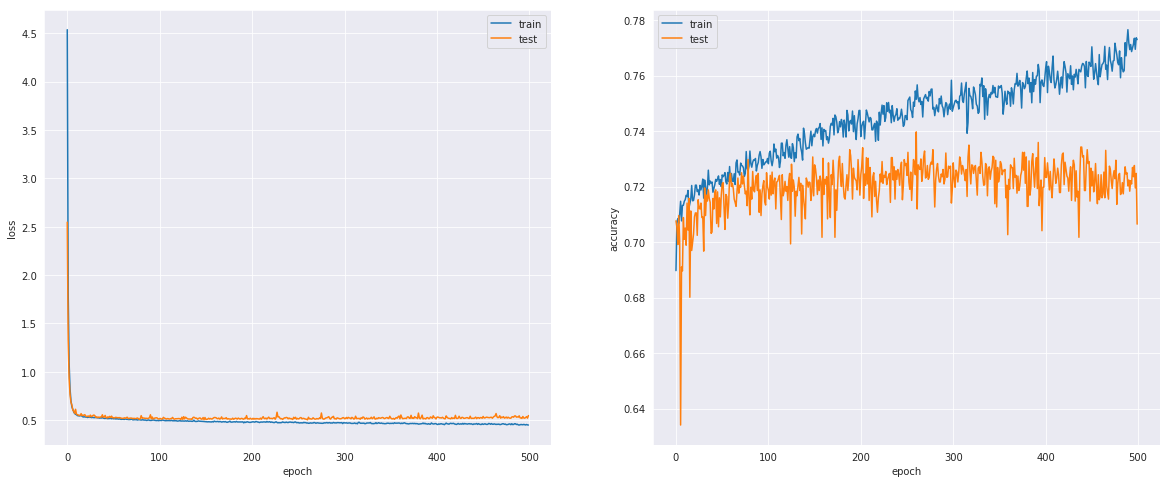

In [20]:
show_results(model,log.history,df_test_x.values,df_test_y.values,256)

## Levels

In [33]:
def show_results_level(model, log,x_test,x_emb_test,y_test,bs,metrics_used):
    metrics_names,metrics = (model.metrics_names,model.evaluate([x_emb_test.values,x_test.values],[y_test.values,y_test.values], batch_size=bs,verbose=False))
    count = 0
    for i in range(0,len(metrics)):
        print(f'{metrics_names[i]}     = {metrics[i]:.4f}')                
    nr_metrics = len(metrics_used)
    fig, axes = plt.subplots(2, nr_metrics, figsize=(18,8))   
    
    i = 0
    for metric in metrics_used:
        match_metrics = [model_metric.split('_')[0] for model_metric in metrics_names if metric in model_metric]
        print(match_metrics)
        if(metric == "loss"):
            match_metrics.remove("loss")
        for match in match_metrics:        
            if(i>=nr_metrics):
                axes[1][i-nr_metrics].plot(log[match + "_" + metric], label="Train")            
                axes[1][i-nr_metrics].plot(log["val_" + match + "_" + metric], label="Val")       
                axes[1][i-nr_metrics].set_xlabel('epoch'); 
                axes[1][i-nr_metrics].set_ylabel(metric + "_" + match)                            
            else:
                axes[0][i].plot(log[match + "_" + metric], label="Train")            
                axes[0][i].plot(log["val_" + match + "_" + metric], label="Val")       
                axes[0][i].set_xlabel('epoch'); 
                axes[0][i].set_ylabel(metric + "_" + match)                            
                
            i += 1            
    for ax in axes:
        for a in ax:
             a.legend()

In [34]:
def show_results_level_RNN(model, log,x_test,x_emb_test,y_test,bs,metrics_used):
    metrics_names,metrics = (model.metrics_names,model.evaluate([x_emb_test.values.reshape(x_emb_test.shape[0],x_emb_test.shape[1],1),x_test.values],[y_test.values,y_test.values], batch_size=bs,verbose=False))
    count = 0
    for i in range(0,len(metrics)):
        print(f'{metrics_names[i]}     = {metrics[i]:.4f}')                
    nr_metrics = len(metrics_used)
    fig, axes = plt.subplots(2, nr_metrics, figsize=(18,8))   
    
    i = 0
    for metric in metrics_used:
        match_metrics = [model_metric.split('_')[0] for model_metric in metrics_names if metric in model_metric]
        print(match_metrics)
        if(metric == "loss"):
            match_metrics.remove("loss")
        for match in match_metrics:        
            if(i>=nr_metrics):
                axes[1][i-nr_metrics].plot(log[match + "_" + metric], label="Train")            
                axes[1][i-nr_metrics].plot(log["val_" + match + "_" + metric], label="Val")       
                axes[1][i-nr_metrics].set_xlabel('epoch'); 
                axes[1][i-nr_metrics].set_ylabel(metric + "_" + match)                            
            else:
                axes[0][i].plot(log[match + "_" + metric], label="Train")            
                axes[0][i].plot(log["val_" + match + "_" + metric], label="Val")       
                axes[0][i].set_xlabel('epoch'); 
                axes[0][i].set_ylabel(metric + "_" + match)                            
                
            i += 1            
    for ax in axes:
        for a in ax:
             a.legend()

In [16]:
def level_model(df_meta_input,df_embeddings,name):    
    input_embedding = Input(shape=(len(df_embeddings.columns),), name='embedding_input')        
    emb_x = Dense(512, activation='relu',use_bias=False,kernel_regularizer=regularizers.l2(0.01))(input_embedding)    
    emb_x = BatchNormalization()(emb_x)
    emb_x = Dropout(0.4)(emb_x)
    emb_x = Dense(512, activation='relu',kernel_regularizer=regularizers.l2(0.01))(emb_x)
    emb_x = Dropout(0.4)(emb_x)
    emb_x = Dense(256, activation='relu',use_bias = False,kernel_regularizer=regularizers.l2(0.01))(emb_x)    
    emb_x = Dropout(0.3)(emb_x)
    emb_x = BatchNormalization()(emb_x)
    emb_x = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01))(emb_x)
    emb_x = Dropout(0.3)(emb_x)
    emb_x = Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01))(emb_x)    
    emb_x = Dropout(0.3)(emb_x)
    emb_x = Dense(32, activation='relu',use_bias = False)(emb_x)
    emb_x = BatchNormalization()(emb_x)
    emb_x = Dense(16, activation='relu',kernel_regularizer=regularizers.l2(0.01))(emb_x)        
    emb_x_out = Dense(3, activation='softmax',name="aux")(emb_x)
    
    
    meta_input = Input(shape=(len(df_meta_input.columns),), name='meta_input')
    x = keras.layers.concatenate([emb_x, meta_input])
    x = Dense(128, activation='relu',use_bias=False)(x)    
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu',use_bias=False,kernel_regularizer=regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu',use_bias=False,kernel_regularizer=regularizers.l2(0.001))(x)   
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='relu',use_bias=False,kernel_regularizer=regularizers.l2(0.001))(x)    
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(16, activation='relu',kernel_regularizer=regularizers.l2(0.0005))(x)    
    x = Dropout(0.1)(x)
    x = Dense(8, activation='relu',use_bias=False,kernel_regularizer=regularizers.l2(0.0005))(x)
    x = BatchNormalization()(x)
    predictions = Dense(3, activation='softmax',name="main")(x)

    # This creates a model that includes
    # the Input layer and three Dense layers                       
    model_created = Model(inputs=[input_embedding, meta_input], outputs=[emb_x_out,predictions])
    model_created.Name = name
    return model_created

In [154]:
def fit_model_level(train_x,train_emb_x,train_y,val_x,val_emb_x,val_y,model_train,n_epochs,optimizer,batchsize,loss_weigths,verb):
    tensorboard = TensorBoard(log_dir=train_filepath + working_level + "/board_logs/" + model_train.name + "-" + model_name + "-{}".format(time()))
    checkpoint = ModelCheckpoint(train_filepath + working_level + "/model_checkpoints/{0}-check-{{epoch:02d}}-{{val_main_acc:.2f}}.hdf5".format(model_train.Name + "-" + model_name),save_weights_only=True, period = int(n_epochs/5))
    best_model_save = ModelCheckpoint(train_filepath + working_level + "/model_checkpoints/{0}-best.hdf5".format(model_train.Name + "-" +  model_name), monitor='val_main_acc',save_weights_only=True,  save_best_only=True, mode='max')
    logger = EpochLogger(display=25)

    model_train.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy',metrics=['accuracy',km.recall()],loss_weights=loss_weigths)
    size = len(train_emb_x)
    return model_train.fit([train_emb_x,train_x], y= [train_y,train_y],verbose = verb,validation_data=([val_emb_x,val_x],[val_y,val_y]),epochs = n_epochs,batch_size=batchsize,callbacks = [tensorboard,checkpoint,best_model_save,logger])  # starts training

In [149]:
df_train_x = df_train.drop(["Is_Ohnolog","Is_Paralog","Dup_Class"],axis=1)
df_train_x = df_train_x.drop(embedding_1_cols,axis=1)
df_train_x = df_train_x.drop(embedding_2_cols,axis=1)

df_train_emb_x = pd.concat([df_train[embedding_1_cols],df_train[embedding_2_cols]],axis=1,sort=False)
df_train_y = df_train["Dup_Class"]

df_val_x = df_val.drop(["Is_Ohnolog","Is_Paralog","Dup_Class"],axis=1)
df_val_x = df_val_x.drop(embedding_1_cols,axis=1)
df_val_x = df_val_x.drop(embedding_2_cols,axis=1)

df_val_emb_x = pd.concat([df_val[embedding_1_cols],df_val[embedding_2_cols]],axis=1,sort=False)
df_val_y = df_val["Dup_Class"]

df_test_x = df_test.drop(["Is_Ohnolog","Is_Paralog","Dup_Class"],axis=1)
df_test_x = df_test_x.drop(embedding_1_cols,axis=1)
df_test_x = df_test_x.drop(embedding_2_cols,axis=1)

df_test_emb_x =  pd.concat([df_test[embedding_1_cols],df_test[embedding_2_cols]],axis=1,sort=False)
df_test_y = df_test["Dup_Class"]

In [28]:
df_train_x.tail()

,Specie_Chicken,Specie_Dog,Specie_Human,Specie_Mouse,Specie_Pig,Specie_Rat,Sequence-1 GC,Sequence-1 Length,Seq-1-Biotype_protein_coding,Sequence-1-Chromosome,...,Nr Mismatch_Total,Nr Gap Open_Total,Evalue_Total,Bit Score_Total,Nr Hits,Cosine_Similarity,Sequence-2 GC,Sequence-2 Length,Sequence-2-Chromosome,Seq-2-Biotype_protein_coding
4754,0,0,0,0,1,0,0.482115,0.005517,1,13,...,0.215159,0.391304,2.309758e-29,0.026779,0.000490,0.949388,0.503550,0.048204,15,1
9416,0,0,0,1,0,0,0.639127,0.035544,1,4,...,0.000000,0.000000,1.434199e-01,0.005392,0.000980,0.815632,0.445312,0.043740,39,1
3454,0,0,0,0,1,0,0.651339,0.031676,1,7,...,0.023472,0.020290,1.226141e-01,0.007485,0.007353,0.977286,0.610080,0.053857,2,1
8414,0,0,0,1,0,0,0.482353,0.031338,1,17,...,0.077751,0.052174,1.916562e-01,0.027952,0.002451,0.976803,0.472843,0.062726,16,1
6761,0,0,0,0,0,1,0.490731,0.026271,1,3,...,0.006724,0.010870,4.941810e-02,0.006502,0.001961,0.934406,0.478372,0.010609,42,1


In [47]:
model = level_model(df_train_x,df_train_emb_x,"Level_model")

In [48]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
embedding_input (InputLayer)    (None, 200)          0                                            
__________________________________________________________________________________________________
dense_28 (Dense)                (None, 512)          102400      embedding_input[0][0]            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 512)          2048        dense_28[0][0]                   
__________________________________________________________________________________________________
dropout_11 (Dropout)            (None, 512)          0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
dense_29 (

In [30]:
reset_weights(model)

In [31]:
log = fit_model_level(df_train_x,df_train_emb_x,df_train_y,df_val_x,df_val_emb_x,df_val_y,model,1000,Adamax(),256,[0.2,1],0)

step: 25/1000 ...  - loss: 3.7666 - val_loss: 3.4420
 - main_loss: 0.9864 - main_acc: 0.5060 - main_recall: 0.0783 - val_main_loss: 0.9351 - val_main_acc: 0.5390 - val_main_recall: 0.0317
 - aux_loss: 1.0687 - aux_acc: 0.4150 - aux_recall: 0.0783 - val_aux_loss: 1.0595 - val_aux_acc: 0.4198 - val_aux_recall: 0.0317
step: 50/1000 ...  - loss: 1.0773 - val_loss: 1.0164
 - main_loss: 0.7627 - main_acc: 0.6763 - main_recall: 0.0841 - val_main_loss: 0.7050 - val_main_acc: 0.7062 - val_main_recall: 0.0588
 - aux_loss: 1.0435 - aux_acc: 0.4347 - aux_recall: 0.0841 - val_aux_loss: 1.0412 - val_aux_acc: 0.4335 - val_aux_recall: 0.0589
step: 75/1000 ...  - loss: 0.9600 - val_loss: 0.9068
 - main_loss: 0.6911 - main_acc: 0.7121 - main_recall: 0.0773 - val_main_loss: 0.6390 - val_main_acc: 0.7381 - val_main_recall: 0.0518
 - aux_loss: 1.0486 - aux_acc: 0.4313 - aux_recall: 0.0773 - val_aux_loss: 1.0463 - val_aux_acc: 0.4272 - val_aux_recall: 0.0519
step: 100/1000 ...  - loss: 0.9070 - val_loss: 0.

loss     = 0.7837
aux_loss     = 1.0227
main_loss     = 0.5522
aux_acc     = 0.4628
aux_recall     = 0.0516
main_acc     = 0.7795
main_recall     = 0.0514
['loss', 'aux', 'main']
['aux', 'main']
['aux', 'main']


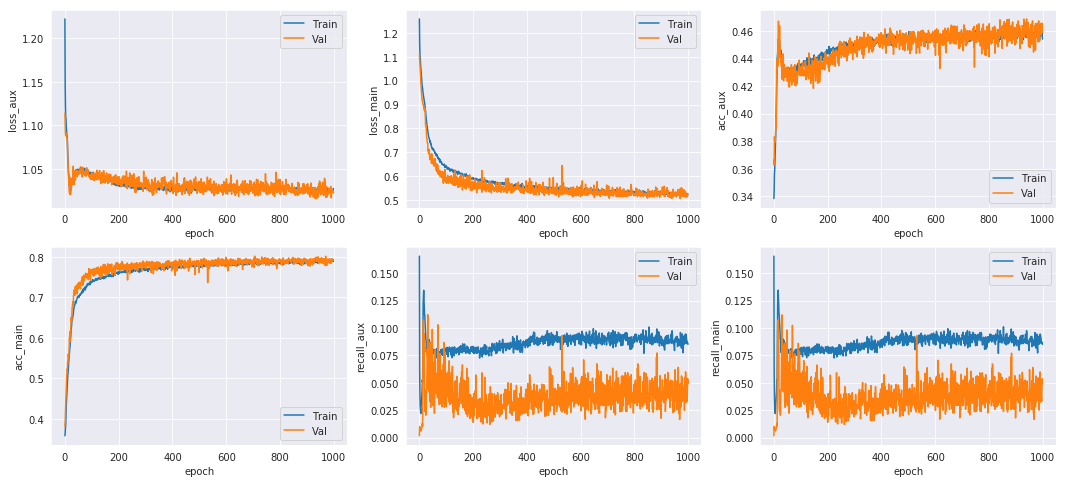

In [32]:
show_results_level(model,log.history,df_test_x,df_test_emb_x,df_test_y,256,["loss","acc","recall"])

In [150]:
def level_model_rnn(df_meta_input,df_embeddings,name,rnn_size,bs):
    input_embedding = Input(shape=(len(df_embeddings.columns),1), name='embedding_input')        
    emb_x = GRU(128,activation="relu",use_bias=False,recurrent_regularizer=kernel_regularizer=regularizers.l1(0.0005),kernel_regularizer=regularizers.l1(0.005))(input_embedding)  
    emb_x = BatchNormalization()(emb_x)    

    emb_x_out = Dense(3, activation='softmax',name="aux")(emb_x)
    
    
    meta_input = Input(shape=(len(df_meta_input.columns),), name='meta_input')
    x = keras.layers.concatenate([emb_x, meta_input])
    x = Dense(128, activation='relu',use_bias=False)(x)    
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu',use_bias=False,kernel_regularizer=regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu',use_bias=False,kernel_regularizer=regularizers.l2(0.001))(x)   
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='relu',use_bias=False,kernel_regularizer=regularizers.l2(0.001))(x)    
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(16, activation='relu',kernel_regularizer=regularizers.l2(0.0005))(x)    
    x = Dropout(0.1)(x)
    x = Dense(8, activation='relu',use_bias=False,kernel_regularizer=regularizers.l2(0.0005))(x)
    x = BatchNormalization()(x)    

    predictions = Dense(3, activation='softmax',name="main")(x)

    # This creates a model that includes
    # the Input layer and three Dense layers                       
    model_created = Model(inputs=[input_embedding, meta_input], outputs=[emb_x_out,predictions])
    model_created.Name = name
    return model_created

In [151]:
model = level_model_rnn(df_train_x,df_train_emb_x,"Level_model_RNN",128,128)

In [152]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
embedding_input (InputLayer)    (None, 200, 1)       0                                            
__________________________________________________________________________________________________
gru_57 (GRU)                    (None, 128)          49536       embedding_input[0][0]            
__________________________________________________________________________________________________
batch_normalization_359 (BatchN (None, 128)          512         gru_57[0][0]                     
__________________________________________________________________________________________________
meta_input (InputLayer)         (None, 40)           0                                            
__________________________________________________________________________________________________
concatenat

In [23]:
df_train_x.head()

,Specie_Chicken,Specie_Dog,Specie_Human,Specie_Mouse,Specie_Pig,Specie_Rat,Sequence-1 GC,Sequence-1 Length,Seq-1-Biotype_protein_coding,Sequence-1-Chromosome,...,Nr Mismatch_Total,Nr Gap Open_Total,Evalue_Total,Bit Score_Total,Nr Hits,Cosine_Similarity,Sequence-2 GC,Sequence-2 Length,Sequence-2-Chromosome,Seq-2-Biotype_protein_coding
11137,0,1,0,0,0,0,0.383559,0.047232,1,19,...,0.004779,0.006917,0.404134,0.005857,0.010784,0.987966,0.396280,0.100525,5,1
10320,0,1,0,0,0,0,0.498495,0.046165,1,12,...,0.000772,0.003432,0.637233,0.005308,0.009314,0.984824,0.521472,0.126786,27,1
3030,0,0,0,0,1,0,0.443734,0.025878,1,5,...,0.178077,0.181159,0.052229,0.028191,0.002941,0.983610,0.418367,0.084437,2,1
8551,0,0,0,1,0,0,0.389572,0.040629,1,11,...,0.000306,0.002717,0.258236,0.005784,0.003922,0.837537,0.591613,0.126409,10,0
3861,0,0,0,0,1,0,0.401408,0.015454,1,5,...,0.000000,0.007246,0.078854,0.005911,0.001471,0.843639,0.571507,0.051915,7,1


In [155]:
log = fit_model_level(df_train_x,df_train_emb_x.values.reshape(df_train_emb_x.shape[0],df_train_emb_x.shape[1],1),df_train_y,df_val_x,df_val_emb_x.values.reshape(df_val_emb_x.shape[0],df_val_emb_x.shape[1],1),df_val_y,model,500,Adamax(),128,[0.2,1],2)

Train on 24862 samples, validate on 6216 samples
Epoch 1/100
 - 52s - loss: 1.6414 - aux_loss: 1.1166 - main_loss: 1.1305 - aux_acc: 0.3887 - aux_recall: 0.0700 - main_acc: 0.3842 - main_recall: 0.0700 - val_loss: 1.5556 - val_aux_loss: 1.0817 - val_main_loss: 1.0632 - val_aux_acc: 0.4151 - val_aux_recall: 0.0118 - val_main_acc: 0.4266 - val_main_recall: 0.0118
Epoch 2/100
 - 50s - loss: 1.5566 - aux_loss: 1.0694 - main_loss: 1.0758 - aux_acc: 0.4202 - aux_recall: 0.0523 - main_acc: 0.4122 - main_recall: 0.0523 - val_loss: 1.5244 - val_aux_loss: 1.0911 - val_main_loss: 1.0476 - val_aux_acc: 0.3930 - val_aux_recall: 0.0216 - val_main_acc: 0.4385 - val_main_recall: 0.0216
Epoch 3/100
 - 50s - loss: 1.5245 - aux_loss: 1.0568 - main_loss: 1.0616 - aux_acc: 0.4327 - aux_recall: 0.0586 - main_acc: 0.4313 - main_recall: 0.0585 - val_loss: 1.4886 - val_aux_loss: 1.0589 - val_main_loss: 1.0320 - val_aux_acc: 0.4334 - val_aux_recall: 0.0780 - val_main_acc: 0.4667 - val_main_recall: 0.0778
Epoch 

KeyboardInterrupt: 

loss     = 1.1415
aux_loss     = 1.0013
main_loss     = 0.9350
aux_acc     = 0.4730
aux_recall     = 0.1311
main_acc     = 0.6973
main_recall     = 0.1311
['loss', 'aux', 'main']
['aux', 'main']
['aux', 'main']


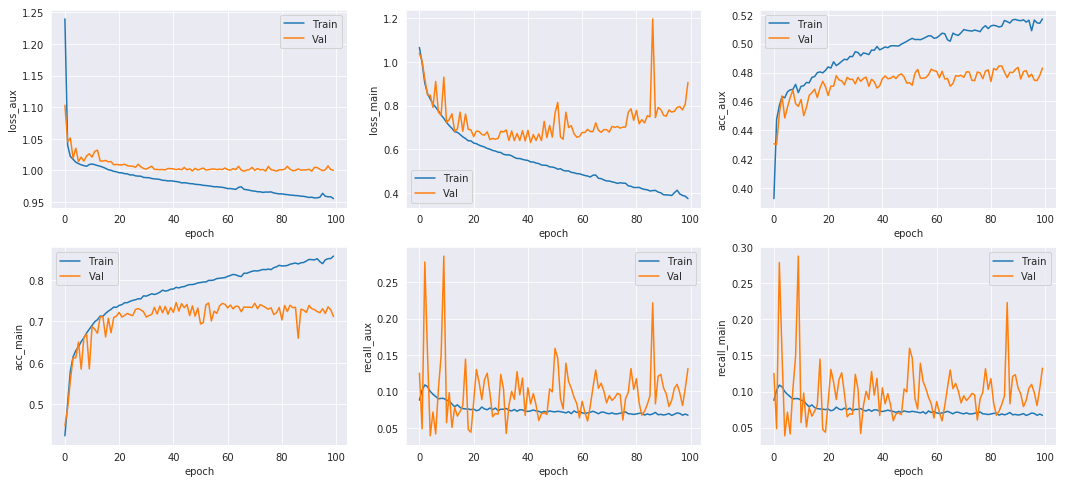

In [25]:
show_results_level_RNN(model,log.history,df_test_x,df_test_emb_x,df_test_y,256,["loss","acc","recall"])

In [ ]:
def level_model_conv(df_meta_input,df_embeddings,name,bs):    
    input_embedding = Input(shape=(len(df_embeddings.columns),len(df_embeddings.columns),1), name='embedding_input')        
    emb_x = Conv2D(64,5, activation='relu')(input_embedding)    
    emb_x = MaxPool2D()(emb_x)
    emb_x = Conv2D(32,4, activation='relu')(emb_x)    
    emb_x = Conv2D(16,3, activation='relu')(emb_x)                
    emb_x = Flatten()(emb_x)
    emb_x_out = Dense(1, activation='sigmoid',name="aux")(emb_x)
        
    meta_input = Input(shape=(len(df_meta_input.columns),), name='meta_input')
    x = keras.layers.concatenate([emb_x, meta_input])    
    x = Dense(128, activation='relu')(x)    
    x = Dense(64, activation='relu')(x)        
    x = Dense(32, activation='relu')(x)    
    x = Dense(16, activation='relu')(x)    
    x = Dense(8, activation='relu')(x)

    predictions = Dense(1, activation='sigmoid',name="main")(x)

    # This creates a model that includes
    # the Input layer and three Dense layers                       
    model_created = Model(inputs=[input_embedding, meta_input], outputs=[emb_x_out,predictions])
    model_created.Name = name
    return model_created

In [ ]:
model = level_model_conv(df_train_x,df_train_emb_x[embedding_1_cols],"Level_model_Conv",256)

In [ ]:
model.summary()

In [ ]:
log = fit_model_level(df_train_x.values,matrix_train,df_train_y.values,df_val_x.values,matrix_test,df_val_y.values,model,500,Adamax(),128,[0.2,1])

## Siames

In [13]:
df_train,df_val,df_test = get_train_val_test_soft(dataset_complete_soft)

In [72]:
import keras.backend as K
from keras.layers import Lambda

def get_tensor_embedding_layer(input_embedding):
    emb_x = Dense(512, activation='elu',use_bias=False,kernel_regularizer=regularizers.l2(0.001))(input_embedding)       
    emb_x = BatchNormalization()(emb_x)
    emb_x = Dropout(0.4)(emb_x)    
    emb_x = Dense(256,use_bias = False, activation='elu',kernel_regularizer=regularizers.l1(0.0005))(emb_x)            
    emb_x = BatchNormalization()(emb_x)    
    emb_x = Dropout(0.4)(emb_x)    
    emb_x = Dense(128,use_bias = False, activation='elu',kernel_regularizer=regularizers.l1(0.0005))(emb_x)            
    emb_x = BatchNormalization()(emb_x)    
    emb_x = Dense(64, use_bias = False, activation='elu',kernel_regularizer=regularizers.l1(0.0005))(emb_x)            
    emb_x = BatchNormalization()(emb_x)    
    emb_x = Dense(32, use_bias = False, activation='elu',kernel_regularizer=regularizers.l1(0.0005))(emb_x)                
    emb_x = BatchNormalization()(emb_x)    
    return emb_x

def level_siames(df_meta_input,df_embeddings_1,df_embeddings_2,name,bs):    
    
    input_embedding_1 = Input(shape=(len(df_embeddings_1.columns),), name='embedding_input_1')        
    input_embedding_2 = Input(shape=(len(df_embeddings_2.columns),), name='embedding_input_2')        
    
    emb_x_1 = get_tensor_embedding_layer(input_embedding_1)    
    emb_x_2 = get_tensor_embedding_layer(input_embedding_2)    
    
    emb_out = keras.layers.concatenate([emb_x_1,emb_x_2])        
         
    emb_out = Dense(3, activation='softmax',name="aux")(emb_out)          
    
    meta_input = Input(shape=(len(df_meta_input.columns),), name='meta_input')
    x = keras.layers.concatenate([emb_x_1,meta_input,emb_x_2])    
    x = Dense(128, activation='relu',use_bias=False)(x)    
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu',use_bias=False,kernel_regularizer=regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu',use_bias=False,kernel_regularizer=regularizers.l2(0.001))(x)   
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='relu',use_bias=False,kernel_regularizer=regularizers.l2(0.001))(x)    
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(16, activation='relu',kernel_regularizer=regularizers.l2(0.0005))(x)    
    x = Dropout(0.1)(x)
    x = Dense(8, activation='relu',use_bias=False,kernel_regularizer=regularizers.l2(0.0005))(x)
    x = BatchNormalization()(x)
    predictions = Dense(3, activation='softmax',name="main")(x)
        
    model_created = Model(inputs=[input_embedding_1,input_embedding_2,meta_input], outputs=[predictions,emb_out])
    model_created.Name = name
    return model_created


In [76]:
import keras.backend as K
from keras.layers import Lambda

def get_tensor_embedding_layer(input_embedding):    
    emb_x = Dense(512, activation='elu',use_bias=False,kernel_regularizer=regularizers.l2(0.001))(input_embedding)       
    emb_x = BatchNormalization()(emb_x)
    emb_x = Dropout(0.4)(emb_x)    
    emb_x = Dense(256,use_bias = False, activation='elu',kernel_regularizer=regularizers.l1(0.0005))(emb_x)            
    emb_x = BatchNormalization()(emb_x)    
    emb_x = Dropout(0.4)(emb_x)    
    emb_x = Dense(128,use_bias = False, activation='elu',kernel_regularizer=regularizers.l1(0.0005))(emb_x)            
    emb_x = BatchNormalization()(emb_x)    
    emb_x = Dense(64, use_bias = False, activation='elu',kernel_regularizer=regularizers.l1(0.0005))(emb_x)            
    emb_x = BatchNormalization()(emb_x)    
    emb_x = Dense(32, use_bias = False, activation='elu',kernel_regularizer=regularizers.l1(0.0005))(emb_x)                
    emb_x = BatchNormalization()(emb_x)    
    return emb_x

def level_siames_merge_layer(df_meta_input,df_embeddings_1,df_embeddings_2,name,bs):    
    
    input_embedding_1 = Input(shape=(len(df_embeddings_1.columns),), name='embedding_input_1')        
    input_embedding_2 = Input(shape=(len(df_embeddings_2.columns),), name='embedding_input_2')        
    
    emb_x_1 = get_tensor_embedding_layer(input_embedding_1)    
    emb_x_2 = get_tensor_embedding_layer(input_embedding_2)    
    
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([emb_x_1, emb_x_2])
    
    emb_x_out = Dense(3, activation='softmax',name="aux")(L1_distance)                
    
    meta_input = Input(shape=(len(df_meta_input.columns),), name='meta_input')    
    
    x = keras.layers.concatenate([L1_distance,meta_input])
    x = Dense(128, activation='relu',use_bias=False)(x)    
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu',use_bias=False,kernel_regularizer=regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu',use_bias=False,kernel_regularizer=regularizers.l2(0.001))(x)   
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='relu',use_bias=False,kernel_regularizer=regularizers.l2(0.001))(x)    
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(16, activation='relu',kernel_regularizer=regularizers.l2(0.0005))(x)    
    x = Dropout(0.1)(x)
    x = Dense(8, activation='relu',use_bias=False,kernel_regularizer=regularizers.l2(0.0005))(x)
    x = BatchNormalization()(x)
    predictions = Dense(3, activation='softmax',name="main")(x)
        
    model_created = Model(inputs=[input_embedding_1,input_embedding_2,meta_input], outputs=[predictions,emb_x_out])
    model_created.Name = name
    return model_created



In [134]:
import keras.backend as K
from keras.layers import Lambda

def get_tensor_embedding_RNN_layer(input_embedding):    
    emb_x = GRU(128,activation="relu",use_bias=False,recurrent_regularizer=kernel_regularizer=regularizers.l1(0.0005),kernel_regularizer=regularizers.l1(0.005))(input_embedding)  
    emb_x = BatchNormalization()(emb_x)    
    return emb_x

def level_siames_merge_RNN_layer(df_meta_input,df_embeddings_1,df_embeddings_2,name,bs):    
    
    input_embedding_1 = Input(shape=(len(df_embeddings_1.columns),1), name='embedding_input_1')        
    input_embedding_2 = Input(shape=(len(df_embeddings_2.columns),1), name='embedding_input_2')        
    
    emb_x_1 = get_tensor_embedding_RNN_layer(input_embedding_1)    
    emb_x_2 = get_tensor_embedding_RNN_layer(input_embedding_2)    
    
    L1_layer = Lambda(lambda tensors:(tensors[0] - tensors[1]))
    L1_distance = L1_layer([emb_x_1, emb_x_2])
   
    
    emb_x_out = Dense(3, activation='softmax',name="aux")(L1_distance)                
    
    meta_input = Input(shape=(len(df_meta_input.columns),), name='meta_input')    
    
    x = keras.layers.concatenate([L1_distance,meta_input])
    x = Dense(256, activation='relu',use_bias=False,kernel_regularizer=regularizers.l1(0.0005))(x)    
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu',use_bias=False,kernel_regularizer=regularizers.l1(0.0005))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu',use_bias=False,kernel_regularizer=regularizers.l1(0.0005))(x)   
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(64, activation='relu',use_bias=False,kernel_regularizer=regularizers.l1(0.0005))(x)    
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='relu',kernel_regularizer=regularizers.l1(0.0005))(x)    
    x = Dropout(0.1)(x)
    x = Dense(16, activation='relu',use_bias=False,kernel_regularizer=regularizers.l1(0.0005))(x)
    x = BatchNormalization()(x)
    predictions = Dense(3, activation='softmax',name="main")(x)
        
    model_created = Model(inputs=[input_embedding_1,input_embedding_2,meta_input], outputs=[predictions,emb_x_out])
    model_created.Name = name
    return model_created


SyntaxError: invalid syntax (<ipython-input-134-460e53f7779f>, line 5)

In [17]:
def euclidean_distance(x,y):    
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)



In [18]:
def fit_model_siames(train_x,train_emb_x_1,train_emb_x_2,train_y,val_x,val_emb_x_1,val_emb_x_2,val_y,model_train,n_epochs,optimizer,batchsize,loss_weigths,verb):
    tensorboard = TensorBoard(log_dir=train_filepath + working_level + "/board_logs/" + model_train.name + "-" + model_name + "-{}".format(time()))
    checkpoint = ModelCheckpoint(train_filepath + working_level + "/model_checkpoints/{0}-check-{{epoch:02d}}-{{val_main_acc:.2f}}.hdf5".format(model_train.name + "-" + model_name),save_weights_only=True,  period = int(n_epochs/5))
    best_model_save = ModelCheckpoint(train_filepath + working_level + "/model_checkpoints/{0}-best.hdf5".format(model_train.name + "-" + model_name), monitor='val_main_acc', save_weights_only=True, save_best_only=True, mode='max')
    logger = EpochLogger(display=25)

    model_train.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy',metrics=['accuracy',km.sparse_categorical_recall()],loss_weights=loss_weigths)    
    return model_train.fit([train_emb_x_1,train_emb_x_2,train_x], y = [train_y,train_y],verbose = verb,validation_data=([val_emb_x_1,val_emb_x_2,val_x],[val_y,val_y]),epochs = n_epochs,batch_size=batchsize,callbacks = [tensorboard,checkpoint,best_model_save,logger])  # starts training

In [22]:
df_train_x = df_train.drop(["Is_Ohnolog","Is_Paralog","Dup_Class"],axis=1)
df_train_x = df_train_x.drop(embedding_1_cols,axis=1)
df_train_x = df_train_x.drop(embedding_2_cols,axis=1)

df_train_emb_x_1 = df_train[embedding_1_cols]
df_train_emb_x_2 = df_train[embedding_2_cols]
df_train_y = df_train["Dup_Class"]

df_val_x = df_val.drop(["Is_Ohnolog","Is_Paralog","Dup_Class"],axis=1)
df_val_x = df_val_x.drop(embedding_1_cols,axis=1)
df_val_x = df_val_x.drop(embedding_2_cols,axis=1)

df_val_emb_x_1 = df_val[embedding_1_cols]
df_val_emb_x_2 = df_val[embedding_2_cols]                  
df_val_y = df_val["Dup_Class"]

df_test_x = df_test.drop(["Is_Ohnolog","Is_Paralog","Dup_Class"],axis=1)
df_test_x = df_test_x.drop(embedding_1_cols,axis=1)
df_test_x = df_test_x.drop(embedding_2_cols,axis=1)

df_test_emb_x_1 =  df_test[embedding_1_cols]
df_test_emb_x_2 =  df_test[embedding_2_cols]
df_test_y = df_test["Dup_Class"]

In [73]:
model = level_siames(df_train_x,df_train_emb_x_1,df_train_emb_x_2,"Level_Siames",128)

In [74]:
log = fit_model_siames(df_train_x.values,df_train_emb_x_1.values,df_train_emb_x_2.values,df_train_y.values,df_val_x.values,df_val_emb_x_1.values,df_val_emb_x_2.values,df_val_y.values,model,1000,Adamax(),256,[1,0.2],0)

step: 25/1000 ...  - loss: 5.5032 - val_loss: 5.1888
 - main_loss: 0.9634 - main_acc: 0.5258 - main_recall: 0.3487 - val_main_loss: 0.9249 - val_main_acc: 0.5560 - val_main_recall: 0.2247
 - aux_loss: 1.0449 - aux_acc: 0.4458 - aux_recall: 0.3487 - val_aux_loss: 1.0401 - val_aux_acc: 0.4372 - val_aux_recall: 0.2250
step: 50/1000 ...  - loss: 1.3075 - val_loss: 1.2759
 - main_loss: 0.7262 - main_acc: 0.6951 - main_recall: 0.5081 - val_main_loss: 0.7029 - val_main_acc: 0.7062 - val_main_recall: 0.4514
 - aux_loss: 1.0066 - aux_acc: 0.4639 - aux_recall: 0.5080 - val_aux_loss: 1.0323 - val_aux_acc: 0.4408 - val_aux_recall: 0.4488
step: 75/1000 ...  - loss: 1.1684 - val_loss: 1.1505
 - main_loss: 0.6731 - main_acc: 0.7209 - main_recall: 0.5429 - val_main_loss: 0.6605 - val_main_acc: 0.7261 - val_main_recall: 0.4970
 - aux_loss: 0.9942 - aux_acc: 0.4738 - aux_recall: 0.5427 - val_aux_loss: 1.0225 - val_aux_acc: 0.4504 - val_aux_recall: 0.4941
step: 100/1000 ...  - loss: 1.1317 - val_loss: 1.

## Siames Merge Layer

In [89]:
model = level_siames_merge_layer(df_train_x,df_train_emb_x_1,df_train_emb_x_2,"Level_Siames",128)

In [90]:
reset_weights(model)

In [91]:
log = fit_model_siames(df_train_x.values,df_train_emb_x_1.values,df_train_emb_x_2.values,df_train_y.values,df_val_x.values,df_val_emb_x_1.values,df_val_emb_x_2.values,df_val_y.values,model,2000,Adamax(),256,[1,0.3],0)

step: 25/2000 ...  - loss: 4.1770 - val_loss: 3.9373
 - main_loss: 0.9416 - main_acc: 0.5422 - main_recall: 0.3900 - val_main_loss: 0.8895 - val_main_acc: 0.5849 - val_main_recall: 0.3359
 - aux_loss: 1.0401 - aux_acc: 0.4610 - aux_recall: 0.3900 - val_aux_loss: 1.0152 - val_aux_acc: 0.4699 - val_aux_recall: 0.3362
step: 50/2000 ...  - loss: 1.4067 - val_loss: 1.3525
 - main_loss: 0.7250 - main_acc: 0.6943 - main_recall: 0.5326 - val_main_loss: 0.6777 - val_main_acc: 0.7184 - val_main_recall: 0.5222
 - aux_loss: 0.9868 - aux_acc: 0.4834 - aux_recall: 0.5325 - val_aux_loss: 0.9984 - val_aux_acc: 0.4742 - val_aux_recall: 0.5203
step: 75/2000 ...  - loss: 1.2167 - val_loss: 1.1855
 - main_loss: 0.6662 - main_acc: 0.7245 - main_recall: 0.5632 - val_main_loss: 0.6356 - val_main_acc: 0.7399 - val_main_recall: 0.5275
 - aux_loss: 0.9738 - aux_acc: 0.4934 - aux_recall: 0.5631 - val_aux_loss: 0.9930 - val_aux_acc: 0.4782 - val_aux_recall: 0.5250
step: 100/2000 ...  - loss: 1.1389 - val_loss: 1.

In [85]:
log = fit_model_siames(df_train_x.values,df_train_emb_x_1.values,df_train_emb_x_2.values,df_train_y.values,df_val_x.values,df_val_emb_x_1.values,df_val_emb_x_2.values,df_val_y.values,model,1500,Adamax(lr=0.006),256,[1,0.2],0)

step: 25/1500 ...  - loss: 3.8034 - val_loss: 3.5694
 - main_loss: 0.9213 - main_acc: 0.5573 - main_recall: 0.3986 - val_main_loss: 0.8725 - val_main_acc: 0.5943 - val_main_recall: 0.3479
 - aux_loss: 1.0374 - aux_acc: 0.4547 - aux_recall: 0.3986 - val_aux_loss: 1.0183 - val_aux_acc: 0.4647 - val_aux_recall: 0.3481
step: 50/1500 ...  - loss: 1.2637 - val_loss: 1.2146
 - main_loss: 0.7280 - main_acc: 0.6905 - main_recall: 0.5251 - val_main_loss: 0.6896 - val_main_acc: 0.7112 - val_main_recall: 0.4817
 - aux_loss: 1.0017 - aux_acc: 0.4716 - aux_recall: 0.5250 - val_aux_loss: 1.0088 - val_aux_acc: 0.4665 - val_aux_recall: 0.4799
step: 75/1500 ...  - loss: 1.1172 - val_loss: 1.0873
 - main_loss: 0.6765 - main_acc: 0.7183 - main_recall: 0.5404 - val_main_loss: 0.6504 - val_main_acc: 0.7325 - val_main_recall: 0.5095
 - aux_loss: 0.9977 - aux_acc: 0.4753 - aux_recall: 0.5403 - val_aux_loss: 1.0099 - val_aux_acc: 0.4658 - val_aux_recall: 0.5069
step: 100/1500 ...  - loss: 1.0567 - val_loss: 1.

## Siames RNN Merge Layer

In [135]:
model = level_siames_merge_RNN_layer(df_train_x,df_train_emb_x_1,df_train_emb_x_2,"Level_Siames_RNN",128)

In [ ]:
log = fit_model_siames(df_train_x.values,df_train_emb_x_1.values.reshape(df_train_emb_x_1.shape[0],df_train_emb_x_1.shape[1],1),df_train_emb_x_2.values.reshape(df_train_emb_x_2.shape[0],df_train_emb_x_2.shape[1],1),df_train_y.values,df_val_x.values,df_val_emb_x_1.values.reshape(df_val_emb_x_1.shape[0],df_val_emb_x_1.shape[1],1),df_val_emb_x_2.values.reshape(df_val_emb_x_2.shape[0],df_val_emb_x_2.shape[1],1),df_val_y.values,model,500,Adamax(),128,[1,0.3],2)

Train on 24862 samples, validate on 6216 samples
Epoch 1/500
 - 46s - loss: 4.4470 - main_loss: 1.1650 - aux_loss: 1.1987 - main_acc: 0.3919 - main_recall: 0.2820 - aux_acc: 0.4029 - aux_recall: 0.2821 - val_loss: 4.1505 - val_main_loss: 1.0488 - val_aux_loss: 1.0983 - val_main_acc: 0.4252 - val_main_recall: 0.2459 - val_aux_acc: 0.4146 - val_aux_recall: 0.2468
Epoch 2/500
 - 43s - loss: 4.0321 - main_loss: 1.0594 - aux_loss: 1.0823 - main_acc: 0.4297 - main_recall: 0.2894 - aux_acc: 0.4262 - aux_recall: 0.2893 - val_loss: 3.8807 - val_main_loss: 1.0326 - val_aux_loss: 1.0851 - val_main_acc: 0.4443 - val_main_recall: 0.2461 - val_aux_acc: 0.4270 - val_aux_recall: 0.2478
Epoch 3/500
 - 44s - loss: 3.7553 - main_loss: 1.0397 - aux_loss: 1.0588 - main_acc: 0.4457 - main_recall: 0.3045 - aux_acc: 0.4371 - aux_recall: 0.3044 - val_loss: 3.6038 - val_main_loss: 1.0164 - val_aux_loss: 1.0628 - val_main_acc: 0.4693 - val_main_recall: 0.2813 - val_aux_acc: 0.4353 - val_aux_recall: 0.2825
Epoch 

## Show Models

In [ ]:
board_dir = train_filepath + working_level + "/model_checkpoints/"

In [ ]:
new_model =  level_model(df_train_x,df_train_emb_x,"Level")
new_model.load_weights(board_dir + new_model.Name + "-complete-8-cdna-best.hdf5")
new_model.compile(optimizer=Adamax(),loss='binary_crossentropy',metrics=['accuracy',km.binary_recall()])
new_log = get_log(new_model.Name + "-complete-8-cdna")

In [ ]:
show_results_level(new_model,new_log,df_test_x,df_test_emb_x,df_test_y,256,["loss","acc","recall"])